In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]
num_root_tweets = len(root_tweet_names)

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = []
for i in range(num_root_tweets):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    
    tweet_dfs.append(tweet_df)

In [4]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

In [5]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [6]:
log_s_j_x = []
for i in range(num_root_tweets):
    s_j_x = sorted(generate_reaction_times(tweet_dfs[i]).values())
    log_s_j_x.append([np.log(i.seconds) for i in s_j_x])

In [8]:
for i in log_s_j_x:
    print(str(np.mean(i)) + " (" + str(np.std(i)) + ")")  

7.7630535704 (2.30126652471)
8.66574824056 (2.08190283732)
7.06974474045 (1.95755497525)
8.72126769419 (1.2168204579)
7.47917776192 (1.85742874384)
7.63218027453 (2.22797323033)
6.95106539283 (2.72326223458)
7.02855191854 (1.77220456665)
6.03438767058 (1.6102895877)
7.33992339908 (1.8133245605)
6.82253918414 (1.90655028468)
7.86957782596 (1.96614772919)
7.49089012366 (1.56160861343)
6.9569969216 (1.91246959961)
7.33325224068 (2.35386272089)
7.61342076773 (1.98749292318)
6.79281312124 (2.40054382543)
7.71603505468 (2.16760837591)
6.45016566397 (1.81456597083)
8.22575308589 (1.89652968124)
6.1100679843 (2.05556980093)
7.89079977067 (1.91900965403)
7.69985857365 (2.55971593768)
6.78997801138 (1.58719311135)
6.75996188371 (1.97337495241)
7.28340022464 (1.99949050843)
7.36632066243 (1.87058630962)
7.76282349379 (1.87473796799)
7.34183510004 (1.61210032737)
7.01868119366 (1.93805896034)
7.34382247072 (2.4400622495)
9.05973632767 (0.900112948761)
6.98833218904 (2.28582272266)
9.0762570917 (0.

In [7]:
# pymc3 model 
with pm.Model() as time_model:
    # global model parameters
    # Time-related hyperparameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sigma_squared_delta = pm.InverseGamma('sigma_squared_delta', alpha=2, beta=2)
    log_a_tau = pm.Normal('log_a_tau', mu=0, sd=10)
    b_tau = pm.Gamma('b_tau', alpha=1, beta=.002)
    
    # log-normal model for reaction times, nonrecursive...
    a_tau = pm.Deterministic('a_tau', pm.math.exp(log_a_tau))
    for i in range(num_root_tweets):
        t_x = pm.InverseGamma('tau_x_squared_' + str(i), alpha=a_tau, beta=b_tau)
        a_x = pm.Normal('alpha_x_' + str(i), mu=alpha, tau=1/sigma_squared_delta)        
        l_x = pm.Normal('log_s_j_x_' + str(i), mu=a_x, sd=t_x**0.5, observed=log_s_j_x[i])

In [ ]:
with pm.Model() as graph_model:
    # Graph-related hyperparameters
    sigma_squared_b = pm.InverseGamma('sigma_squared_b', alpha=0.5, beta=0.5, testval=10000)
    beta_0 = pm.Normal('beta_0', mu=0, tau=1/sigma_squared_b, testval=1.99)
    beta_F = pm.Normal('beta_F', mu=0, tau=1/sigma_squared_b, testval=-0.79)
    beta_d = pm.Normal('beta_d', mu=0, tau=1/sigma_squared_b, testval=)
    
    


In [13]:
# Run and fit our model
with time_model:
    trace = pm.sample(1000, tune=2000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_x_51, tau_x_squared_51_log__, alpha_x_50, tau_x_squared_50_log__, alpha_x_49, tau_x_squared_49_log__, alpha_x_48, tau_x_squared_48_log__, alpha_x_47, tau_x_squared_47_log__, alpha_x_46, tau_x_squared_46_log__, alpha_x_45, tau_x_squared_45_log__, alpha_x_44, tau_x_squared_44_log__, alpha_x_43, tau_x_squared_43_log__, alpha_x_42, tau_x_squared_42_log__, alpha_x_41, tau_x_squared_41_log__, alpha_x_40, tau_x_squared_40_log__, alpha_x_39, tau_x_squared_39_log__, alpha_x_38, tau_x_squared_38_log__, alpha_x_37, tau_x_squared_37_log__, alpha_x_36, tau_x_squared_36_log__, alpha_x_35, tau_x_squared_35_log__, alpha_x_34, tau_x_squared_34_log__, alpha_x_33, tau_x_squared_33_log__, alpha_x_32, tau_x_squared_32_log__, alpha_x_31, tau_x_squared_31_log__, alpha_x_30, tau_x_squared_30_log__, alpha_x_29, tau_x_squared_29_log__, alpha_x_28, tau_x_squared_28_log__, alpha_x_27

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


alpha: 7.31643926259(0.102637427799)
sigma_squared_delta: 0.542208463816(0.110461385695)
a_tau: 5.76763305196(1.25616723428)
b_tau: 19.0473806323(4.32872533425)


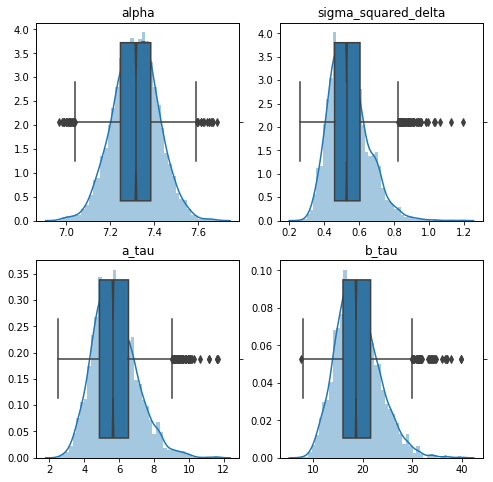

In [32]:
# graph all of the important distributions
with twitter_model:
    imp_dists = ['alpha', 'sigma_squared_delta', 'a_tau', 'b_tau']
    fig, axs = plt.subplots(2,2, figsize = (8,8))
    for i in range(len(imp_dists)):
        ax1 = axs[int(i/2)][i%2]
        ax2 = ax1.twinx()
        ax2.set(ylim=(-.25, .25))
        var = imp_dists[i]
        sns.distplot(trace[var], ax=ax1).set_title(var);
        sns.boxplot(trace[var], ax=ax2, notch=True)
        print(var + ": " + str(np.mean(trace[var])) + "(" + str(np.std(trace[var])) + ")")
